# $\fbox{4-2}$ セミパラメトリック分析 ~ 区間推定

## 最尤推定法による重みベクトルの区間推定

### クラメール・ラオの限界

### フィッシャー情報行列

### ベクトルに関する微分公式

## Cox 比例ハザードモデル（Breslow 部分尤度）への適用

### 対数尤度関数

### 対数尤度関数のヘッセ行列


## 本書モデルへの適用

### 対数尤度関数とヘッセ行列

## データ分析


In [1]:
%matplotlib notebook

import gc
import math
import pickle

# 本書 4 章の関数群を含む自作ライブラリ
import mylibs.mylib4 as mylib4

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

pd.options.display.max_rows = 6
pd.options.display.max_columns = 12

In [2]:
f = open('./pseudo_medical/processed/incl_bp/dict_bp.binaryfile', 'rb')  # rb: Read Binary
dict_bp = pickle.load(f)
f.close()

print(dict_bp['M']['exp']['class'][60])

[2.0 3.0 3.0 ... 4.0 4.0 4.0]


In [3]:
f = open('./pseudo_medical/processed/incl_bp/opt_result.binaryfile', 'rb')  # rb: Read Binary
opt_result = pickle.load(f)
f.close()

w = opt_result.x[0]
print(w) 

0.33310546874999997


In [4]:
sex, x = 'M', 60
print('beta =', mylib4.beta(dict_bp, w, sex, x))

beta = 2876.9796256179907


In [5]:
def gamma(dict_bp, w, sex, x):
    exp_classes = dict_bp[sex]['exp']['class'][x].astype('f8')
    return (np.exp(w * exp_classes) * (exp_classes ** 2)).sum()


sex, x = 'M', 60
gamma(dict_bp, w, sex, x)

26039.935583571812

In [6]:
def delta(dict_bp, w, sex, x):
    exp_classes = dict_bp[sex]['exp']['class'][x].astype('f8')
    return (np.exp(w * exp_classes) * exp_classes).sum()


sex, x = 'M', 60
delta(dict_bp, w, sex, x)

7864.594639374024

In [7]:
def zeta(dict_bp, w, sex, x):
    f1 = len(dict_bp[sex]['out']['class'][x].astype('f8'))
    beta = mylib4.beta(dict_bp, w, sex, x)
    f2 = gamma(dict_bp, w, sex, x) / beta
    f3 = (delta(dict_bp, w, sex, x) / beta)**2
    return - f1 * (f2 - f3)


zeta(dict_bp, w, sex, x)

-36.30342206032749

In [8]:
def hesse(dict_bp, w):
    h = None
    for sex in ['M', 'F']:
        for x in np.arange(65):
            try:
                z = zeta(dict_bp, w, sex, x)
                try:
                    h = h + z
                except:
                    h = z
            except:
                pass
    return h


hesse(dict_bp, w)

-1080.0044990505028

In [9]:
def stdev(dict_bp, w):
    return (-1 / hesse(dict_bp, w))**0.5


sigma = stdev(dict_bp, w)
sigma

0.03042896759226878

In [10]:
lcl = w - 1.96 * sigma
ucl = w + 1.96 * sigma

print('LCL(w*) =', lcl)
print('    w*  =', w)
print('UCL(w*) =', ucl)

LCL(w*) = 0.27346469226915315
    w*  = 0.33310546874999997
UCL(w*) = 0.3927462452308468


## 参考：ベースライン発生率の分散

### 積の分散公式

### イェンセンの不等式


<IPython.core.display.Javascript object>


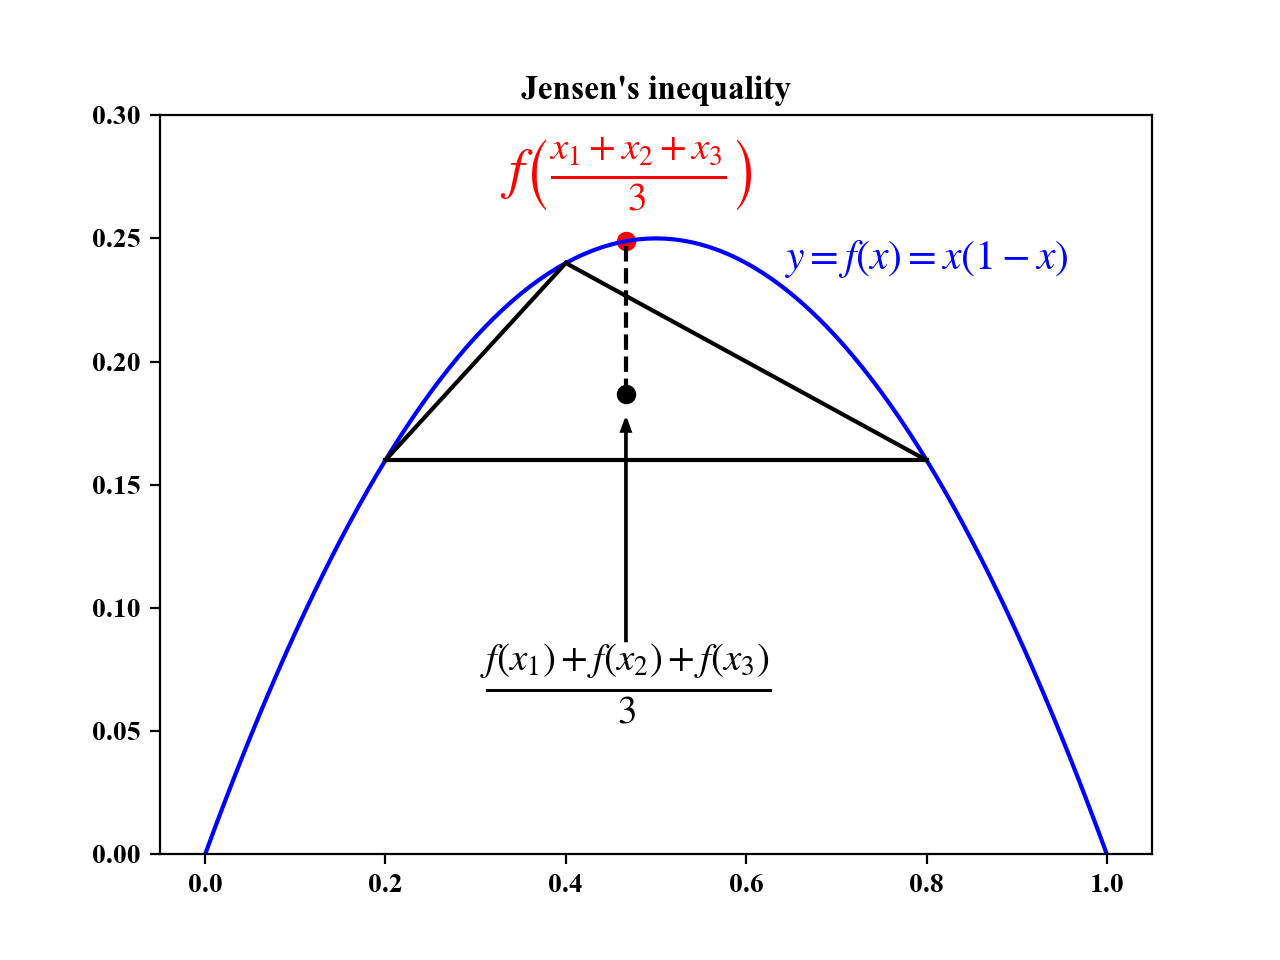

Text(0.5, 1.0, "Jensen's inequality")

In [11]:
def f(x):
    return x * (1 - x)


fig = plt.figure()
ax = fig.add_subplot(111)
# y = f(x) = x(1-x)
x = np.arange(101) / 100
y = f(x)
ax.plot(x, y, c='b')
ax.text(0.8, 0.25, r'$y = f(x) = x(1-x)$', ha='center', va='top', color='b', fontsize=15)
# 三角形
x = np.array([0.2, 0.4, 0.8])
y = f(x)
ax.plot(x[:2], y[:2], c='k')
ax.plot(x[1:], y[1:], c='k')
ax.plot([x[0], x[2]], [y[0], y[2]], c='k')
# 三角形の重心
x, y = x.sum()/3, y.sum()/3
ax.scatter(x, y, c='k')
ax.text(x, y-0.1, r'$\frac{f(x_1) + f(x_2) + f(x_3)}{3}$', ha='center', va='top', fontsize=20)
ax.arrow(x, y-0.1 ,dx=0, dy=0.09,
         width=0.001, head_width=0.01, head_length=0.005,
         length_includes_head=True, color='k')
# 重心から f(x) に伸ばした点
ax.plot([x, x], [y, f(x)], c='k', ls='--')
ax.scatter(x, f(x), c='r')
ax.text(x, 0.26, r'$f\left( \frac{x_1 + x_2 + x_3}{3} \right)$', ha='center', va='bottom', color='red', fontsize=20)
# 共通
ax.set_ylim([0, 0.3])
ax.set_title("Jensen's inequality")

### ベースライン発生率の分散の評価

In [12]:
def U(sex, x):
    E = len(dict_bp[sex]['exp']['class'][x].astype('f8'))
    O = len(dict_bp[sex]['out']['class'][x].astype('f8'))
    return O * (1 - O / E)


sex, x = 'M', 60
sex, x, U(sex, x)

('M', 60, 22.581818181818182)

In [13]:
def T(dict_bp, sex, x, w, sigma):
    exp_classes = dict_bp[sex]['exp']['class'][x].astype('f8')
    return ((np.exp(w * exp_classes) * exp_classes)**2).sum() * (sigma**2)

sex, x, w, sigma, T(dict_bp, sex, x, w, sigma)

('M', 60, 0.33310546874999997, 0.03042896759226878, 85.69364465937639)

In [14]:
def VX(sex, x, w, sigma, baseline):
    nume = U(sex, x) - baseline**2 * T(dict_bp, sex, x, w, sigma)
    deno = T(dict_bp, sex, x, w, sigma) + mylib4.beta(dict_bp, w, sex, x)**2
    return nume / deno

In [15]:
def get_baseline(df_summary, sex, age):
    is_sex = (df_summary['sex'] == sex)
    is_age = (df_summary['age'] == age)
    return df_summary.loc[is_sex & is_age, 'baseline'].values[0]


df_summary = pd.read_csv('./pseudo_medical/processed/incl_bp/df_summary.csv')

sex, age = 'M', 60
get_baseline(df_summary, sex, age)

0.007994495266910163

In [16]:
def add_baseline_CI(df_summary, sex, age, w, sigma):
    baseline = get_baseline(df_summary, sex, age)
    is_sex = (df_summary['sex'] == sex)
    is_age = (df_summary['age'] == age)
    vx = VX(sex, x, w, sigma, baseline)
    df_summary.loc[is_sex & is_age, 'baseline_LCL'] = baseline - 1.96 * vx
    df_summary.loc[is_sex & is_age, 'baseline_UCL'] = baseline + 1.96 * vx
    return df_summary


def add_baseline_CIs(df_summary, w, sigma):
    df_summary['baseline_LCL'] = 0
    df_summary['baseline_UCL'] = 0
    for sex in ['M', 'F']:
        for age in np.arange(65):
            df_summary = add_baseline_CI(df_summary, sex, age, w, sigma)
    return df_summary


df_summary = add_baseline_CIs(df_summary, w, sigma)

df_summary

,sex,age,out,exp,beta,rate,baseline,baseline_LCL,baseline_UCL
0,M,0.0,3.0,314.0,390.033267,0.009554,0.007692,0.007686,0.007697
1,M,1.0,1.0,677.0,860.863440,0.001477,0.001162,0.001156,0.001167
2,M,2.0,7.0,796.0,1011.510175,0.008794,0.006920,0.006915,0.006926
...,...,...,...,...,...,...,...,...,...
127,F,62.0,17.0,1448.0,2906.680608,0.011740,0.005849,0.005843,0.005854
128,F,63.0,21.0,1356.0,2839.252421,0.015487,0.007396,0.007391,0.007402
129,F,64.0,13.0,1243.0,2599.738200,0.010459,0.005001,0.004995,0.005006


<IPython.core.display.Javascript object>


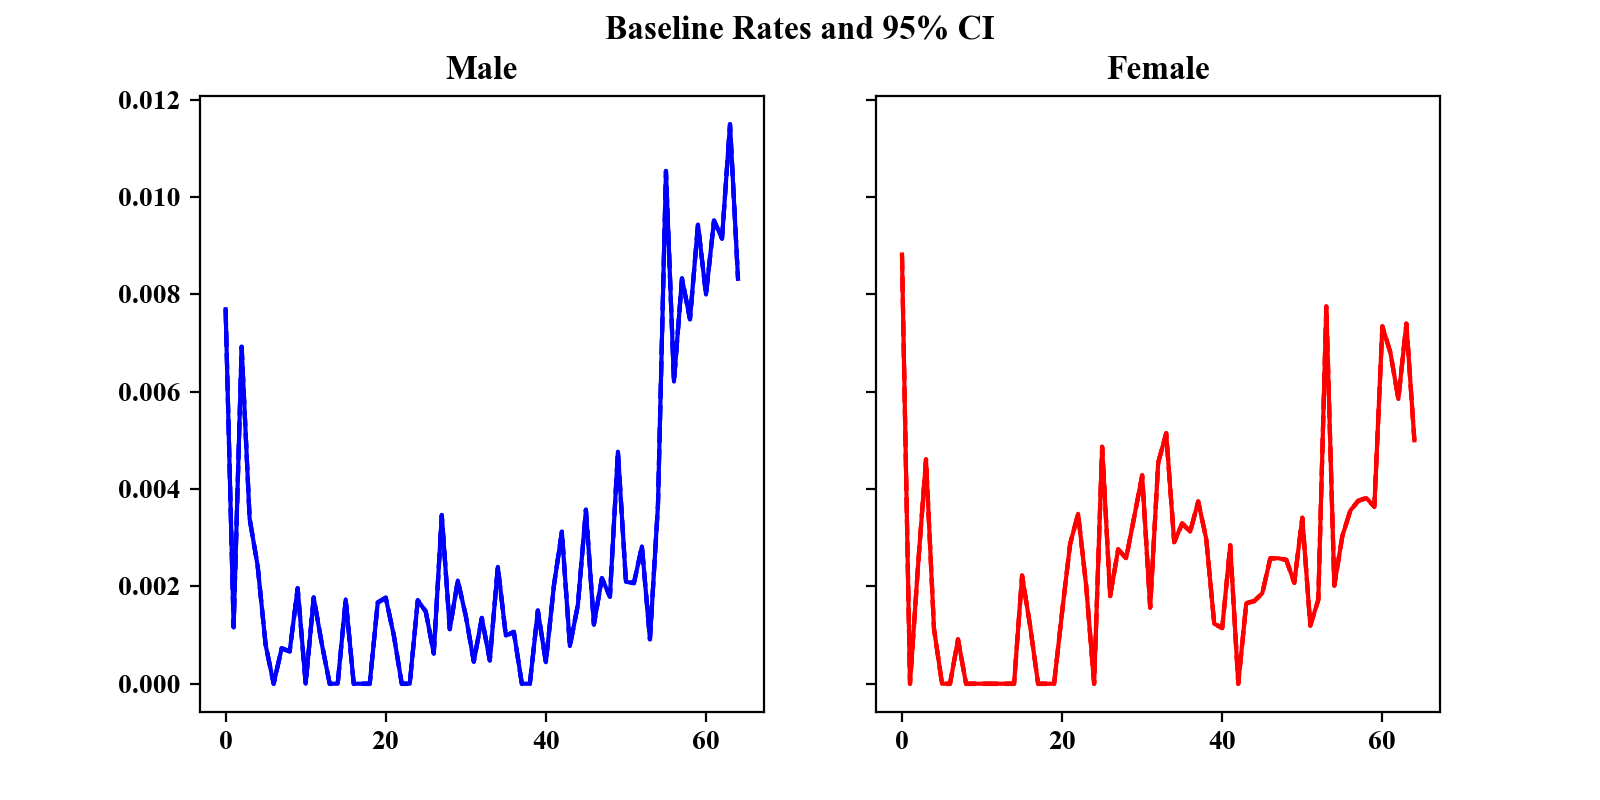

Text(0.5, 0.98, 'Baseline Rates and 95% CI')

In [17]:
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(1, 2, sharex=True, sharey=True)
# 男性
ax = axes[0]
df = df_summary[df_summary['sex'] == 'M']
ax.plot(df['age'], df['baseline'], c='b')
ax.plot(df['age'], df['baseline_LCL'], c='b', ls='--')
ax.plot(df['age'], df['baseline_UCL'], c='b', ls='--')
ax.set_title('Male')
# 女性
ax = axes[1]
df = df_summary[df_summary['sex'] == 'F']
ax.plot(df['age'], df['baseline'], c='r')
ax.plot(df['age'], df['baseline_LCL'], c='r', ls='--')
ax.plot(df['age'], df['baseline_UCL'], c='r', ls='--')
ax.set_title('Female')
# 共通
fig.suptitle('Baseline Rates and 95% CI')

In [18]:
df_summary.to_csv('./pseudo_medical/processed/incl_bp/df_summary_with_CI.csv', index=False)

## まとめ